In [ ]:
import pathlib

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

from PIL import Image

import datetime


In [2]:
DATA_BASE_DIR=pathlib.Path('../data/dataset/data')

In [3]:
manufacturer_df= pd.read_csv(DATA_BASE_DIR/"images_manufacturer_train.txt",
            sep=" ",
            names=["image_id","manufacturer"],
            dtype={"image_id": str}, #to force the image_id to be a string,
        )

# Check integrity of the file

In [4]:
manufacturer_df['manufacturer'].value_counts(dropna=False)

Boeing         733
Airbus         434
Embraer        233
McDonnell      232
de             167
Canadair       134
Douglas        133
British        133
Cessna         133
Lockheed       102
Fokker         100
Dassault        67
Beechcraft      67
Saab            67
Gulfstream      67
ATR             66
Tupolev         66
Dornier         34
Yakovlev        34
Antonov         34
Panavia         34
Robin           33
Piper           33
Ilyushin        33
Bombardier      33
Cirrus          33
Supermarine     33
Eurofighter     33
Fairchild       33
Name: manufacturer, dtype: int64

In [5]:
manufacturer_df.isna().sum()

image_id        0
manufacturer    0
dtype: int64

In [6]:
for col in manufacturer_df.columns : 
    assert manufacturer_df[col].isna().sum() == 0 , "Missing value unexpected"


# Deal with N columns

## Make assumptions about number of spaces (here = 2) 
Naive method

In [7]:
manufacturer_df= pd.read_csv(DATA_BASE_DIR/"images_manufacturer_train.txt",
            sep=" ",
            names=["image_id","m1","m2"],
            usecols=["image_id","m1","m2"],
            dtype={"image_id": str} #to force the image_id to be a string 
        )
manufacturer_df["manufacturer"]= manufacturer_df["m1"]+ ' '+manufacturer_df["m2"]
manufacturer_df["manufacturer"].unique()

array([nan, 'British Aerospace', 'Lockheed Corporation',
       'Douglas Aircraft', 'McDonnell Douglas', 'de Havilland',
       'Lockheed Martin', 'Dassault Aviation', 'Bombardier Aerospace',
       'Gulfstream Aerospace', 'Cirrus Aircraft'], dtype=object)

In [8]:
!grep "T" ../data/dataset/data/images_manufacturer_train.txt | head -3

0724121 ATR
0619697 ATR
2243949 ATR


In [9]:
!grep "T" ../data/dataset/data/images_manufacturer_train.txt | wc -l

132


In [88]:
manufacturer_df= pd.read_csv(DATA_BASE_DIR/"images_manufacturer_train.txt",
            names=["all"],
        )
manufacturer_df["image_id"]=manufacturer_df["all"].apply(lambda x: x.split(' ')[0])
manufacturer_df["manufacturer"]=manufacturer_df["all"].apply(lambda x: ' '.join(x.split(' ')[1:]))
manufacturer_df["manufacturer"].unique()

array(['Boeing', 'Airbus', 'ATR', 'Antonov', 'British Aerospace',
       'Beechcraft', 'Lockheed Corporation', 'Douglas Aircraft Company',
       'Canadair', 'Cessna', 'McDonnell Douglas', 'de Havilland', 'Robin',
       'Dornier', 'Embraer', 'Eurofighter', 'Lockheed Martin',
       'Dassault Aviation', 'Fokker', 'Bombardier Aerospace',
       'Gulfstream Aerospace', 'Ilyushin', 'Fairchild', 'Piper',
       'Cirrus Aircraft', 'Saab', 'Supermarine', 'Panavia', 'Tupolev',
       'Yakovlev'], dtype=object)

In [10]:
manufacturer_df.head()

,image_id,m1,m2,manufacturer
0,1025794,Boeing,NaN,NaN
1,1340192,Boeing,NaN,NaN
2,0056978,Boeing,NaN,NaN
3,0698580,Boeing,NaN,NaN
4,0450014,Boeing,NaN,NaN


In [14]:
manufacturer_df["path"]= manufacturer_df['image_id'].apply( lambda x: pathlib.Path("../data/dataset/data")/"images"/(x+'.jpg')) 

In [15]:
manufacturer_df.head()

,image_id,m1,m2,manufacturer,path
0,1025794,Boeing,NaN,NaN,../data/dataset/data/images/1025794.jpg
1,1340192,Boeing,NaN,NaN,../data/dataset/data/images/1340192.jpg
2,0056978,Boeing,NaN,NaN,../data/dataset/data/images/0056978.jpg
3,0698580,Boeing,NaN,NaN,../data/dataset/data/images/0698580.jpg
4,0450014,Boeing,NaN,NaN,../data/dataset/data/images/0450014.jpg


In [3]:
def build_image_database(path,target):
    """    Build a pandas dataframe with target class and access path to images.

    Parameters:
        - path (Path): Path pattern to read csv file containing images information
        - target(str): The second column to extract from the file

    Return:
        A pandas dataframe,
    -------
    """
    #Load file
    _df= pd.read_csv(path,
            names=["all"],
        )
    #Recover data
    _df["image_id"]=_df["all"].apply(lambda x: x.split(' ')[0])
    _df[target]=_df["all"].apply(lambda x: ' '.join(x.split(' ')[1:]))
    _df[target].unique()

    #Create path
    _df["path"]= _df['image_id'].apply( lambda x: pathlib.Path("../data/dataset/data")/"images"/(x+'.jpg')) 
    
    return _df.drop(columns=["all"])

# Load manufacturer dataset

In [9]:
build_image_database(DATA_BASE_DIR/"images_manufacturer_train.txt","manufacturer").head(2)

,image_id,manufacturer,path
0,1025794,Boeing,../data/dataset/data/images/1025794.jpg
1,1340192,Boeing,../data/dataset/data/images/1340192.jpg


In [10]:
build_image_database(DATA_BASE_DIR/"images_family_train.txt","family").head(2)

,image_id,family,path
0,1025794,Boeing 707,../data/dataset/data/images/1025794.jpg
1,1340192,Boeing 707,../data/dataset/data/images/1340192.jpg


In [11]:
build_image_database(DATA_BASE_DIR/"images_variant_train.txt","variant").head(2)

,image_id,variant,path
0,1025794,707-320,../data/dataset/data/images/1025794.jpg
1,1340192,707-320,../data/dataset/data/images/1340192.jpg


In [4]:
manufacturer_df= build_image_database(DATA_BASE_DIR/"images_manufacturer_train.txt","manufacturer")

In [13]:
manufacturer_df.head(2)

,image_id,manufacturer,path
0,1025794,Boeing,../data/dataset/data/images/1025794.jpg
1,1340192,Boeing,../data/dataset/data/images/1340192.jpg


In [5]:
def show_image(df,row,target):
    """show the image in the ligne row and the associated target column

    Args:
        df (pandas.dataFrame): the dataframe of images
        row (int): the index of the row
        target (string): the column name of the associated label
    Return
    ------
    None
    """

    assert target in df.columns, f"Column {target} not found in dataframe"
    assert 'path' in df.columns, f"Column path doens't not exit in dataframe"
    _img = plt.imread(df.loc[row,'path'])
    print(df.loc[row,target])
    plt.imshow(_img)
    return

Boeing


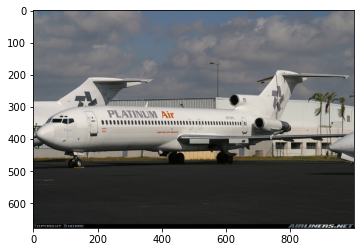

In [6]:
show_image(manufacturer_df,42,'manufacturer')

Boeing 707


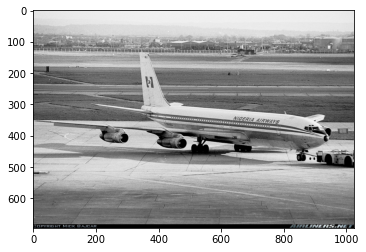

In [7]:
show_image(build_image_database(DATA_BASE_DIR/'images_family_train.txt','family'),24,'family')

In [17]:
manufacturer_df["image_shape"] =manufacturer_df["path"].apply(lambda p: plt.imread(p).shape)

In [18]:
manufacturer_df["image_shape"].apply(lambda x: x[0]).value_counts()

695     627
812     310
678     271
679     186
694     107
       ... 
467       1
469       1
477       1
479       1
1181      1
Name: image_shape, Length: 404, dtype: int64

In [77]:
manufacturer_df["image_shape"].apply(lambda x: x[1]).value_counts()

1024    1399
1200     618
1000     492
1600     145
1050     105
        ... 
1016       1
775        1
913        1
941        1
1595       1
Name: image_shape, Length: 73, dtype: int64

# Constante

In [8]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=IMAGE_WIDTH
IMAGE_DEPTH = 3

In [9]:
def load_resize_image(path,height,width):
    """Load an image and resize it to the target size

    Parameters:
        - path (Path): path to the file to load and resize
        - height (int): the height of the final resized image
        - width(int): the width of the resized image 
    Return
    ------
    numpy.array containing resized image
    """

    return np.array(Image.open(path).resize((width,height)))

In [85]:
manufacturer_df.head(10).apply(lambda r: load_resize_image(r['path'],IMAGE_HEIGHT,IMAGE_WIDTH),axis=1)

0    [[[219, 219, 219], [219, 219, 219], [219, 219,...
1    [[[212, 212, 212], [220, 220, 220], [196, 196,...
2    [[[131, 167, 205], [134, 168, 206], [134, 168,...
3    [[[48, 63, 68], [49, 64, 69], [50, 64, 69], [4...
4    [[[116, 160, 231], [116, 160, 232], [116, 161,...
5    [[[202, 202, 202], [202, 202, 202], [201, 201,...
6    [[[37, 93, 129], [37, 94, 129], [38, 94, 129],...
7    [[[171, 171, 171], [172, 172, 172], [172, 172,...
8    [[[192, 190, 195], [192, 190, 195], [193, 191,...
9    [[[107, 140, 156], [109, 141, 158], [110, 143,...
dtype: object

In [12]:
manufacturer_df['resized_image'] = manufacturer_df.apply(lambda r: load_resize_image(r['path'],IMAGE_HEIGHT,IMAGE_WIDTH),axis=1)

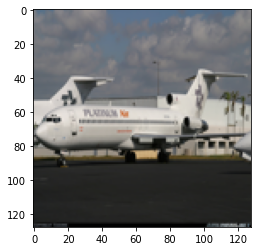

In [24]:
plt.imshow(manufacturer_df.loc[42,'resized_image'])

In [13]:
def build_classification_model(df: pd.DataFrame,target: str, images: str):
    """Build a tensorflow model using information from target and images columns in dataframes
    Parameters
    ----------
        - df (pandas.dataFrame): dataframe with target and images columns
        - target (str): column name for target variable
        - images (str): column name for images
    Returns
    ------
    tensorflow model built & compiled
    """
    
    #Compute number of classes for output layer
    nb_classes = df[target].nunique()
    
    # Computer images size for input layer
    size = df[images].iloc[0].shape
    
    # Building the model
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=size))
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(nb_classes , activation='softmax'))

    #Compilation of the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #output layer of nb_classes
    
    return model

In [14]:
build_classification_model(manufacturer_df,'manufacturer','resized_image')

In [25]:
# Compute the number of classes to shape the output layer
nb_classes = manufacturer_df.manufacturer.nunique()
nb_classes

30

In [26]:
#Building the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_DEPTH)))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(nb_classes , activation='softmax'))

#Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #output layer of nb_classes


In [27]:
y=tf.keras.utils.to_categorical (manufacturer_df['manufacturer'].astype('category').cat.codes)

# Build train & Test set

In [31]:
def build_x_and_y(df: pd.DataFrame, target: str, images: str, stratify: str=None):
    """build x tensor and y tensor for model fitting.
    parameters
    ----------
    df(pd.DataFrame): dataframe 
    target(str): name of target column
    images (str): name of images column
        
    Returns
    -------
    
    x (numpy.array): tensor of x values
    y (numpy.array): tensor of y values
    """
    
    x= np.array(df[images].to_list())
    y=tf.keras.utils.to_categorical (df[target].astype('category').cat.codes)
    return x,y

In [28]:
X_train, X_test,y_train,y_test =  train_test_split(manufacturer_df[['resized_image',"manufacturer"]],y,test_size=0.2,stratify=manufacturer_df['manufacturer'])

In [29]:
assert X_train.shape[0]+X_test.shape[0]== manufacturer_df.shape[0]
assert y_train.shape[0]+y_test.shape[0]== y.shape[0]

In [30]:
X_train['manufacturer'].value_counts(normalize=True)

Boeing                      0.219723
Airbus                      0.130109
Embraer                     0.069741
McDonnell Douglas           0.069741
de Havilland                0.050244
Canadair                    0.040120
British Aerospace           0.039745
Douglas Aircraft Company    0.039745
Cessna                      0.039745
Fokker                      0.029996
Saab                        0.020247
Beechcraft                  0.020247
Dassault Aviation           0.020247
Gulfstream Aerospace        0.020247
Lockheed Corporation        0.020247
Tupolev                     0.019873
ATR                         0.019873
Bombardier Aerospace        0.010124
Panavia                     0.010124
Piper                       0.010124
Fairchild                   0.010124
Yakovlev                    0.010124
Supermarine                 0.010124
Antonov                     0.010124
Lockheed Martin             0.010124
Dornier                     0.010124
Robin                       0.009749
I

In [31]:
X_test['manufacturer'].value_counts(normalize=True)

Boeing                      0.220390
Airbus                      0.130435
Embraer                     0.070465
McDonnell Douglas           0.068966
de Havilland                0.049475
Canadair                    0.040480
British Aerospace           0.040480
Cessna                      0.040480
Douglas Aircraft Company    0.040480
Fokker                      0.029985
Lockheed Corporation        0.020990
ATR                         0.019490
Dassault Aviation           0.019490
Beechcraft                  0.019490
Saab                        0.019490
Gulfstream Aerospace        0.019490
Tupolev                     0.019490
Yakovlev                    0.010495
Eurofighter                 0.010495
Panavia                     0.010495
Robin                       0.010495
Dornier                     0.010495
Cirrus Aircraft             0.010495
Ilyushin                    0.010495
Antonov                     0.010495
Lockheed Martin             0.010495
Piper                       0.008996
F

# Train model 

In [19]:
%%time 
epochs = 5
history = model.fit(np.array(X_train['resized_image'].to_list()),y_train,batch_size = 32,epochs = epochs , validation_data = (np.array(X_test['resized_image'].to_list()),y_test))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [32]:
#Load train & test dataset
train_df = build_image_database(DATA_BASE_DIR/'images_manufacturer_train.txt','manufacturer')
test_df = build_image_database(DATA_BASE_DIR/'images_manufacturer_test.txt','manufacturer')

train_df['resized_image'] = train_df.apply(lambda r: load_resize_image(r['path'],IMAGE_HEIGHT,IMAGE_WIDTH),axis=1)
test_df['resized_image'] = test_df.apply(lambda r: load_resize_image(r['path'],IMAGE_HEIGHT,IMAGE_WIDTH),axis=1)

#Build tensors for training & testing
X_train,y_train = build_x_and_y(train_df,'manufacturer','resized_image')
X_test,y_test = build_x_and_y(test_df,'manufacturer','resized_image')

model = build_classification_model(train_df,"manufacturer","resized_image")

In [33]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape, test_df.shape

((3334, 128, 128, 3), (3334, 30), (3333, 128, 128, 3), (3333, 30), (3333, 4))

In [34]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime

!rm -rf ./logs
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
rm: cannot remove './logs/fit/20220318-142449/train': Directory not empty


In [36]:
%%time 
epochs = 5
history = model.fit(X_train,y_train,batch_size = 32,epochs = epochs , validation_data = (X_test,y_test),
                   callbacks=[tensorboard_callback]
                   )

Epoch 1/5
105/105 [==============================] - 129s 1s/step - loss: 2.4970 - accuracy: 0.2726 - val_loss: 2.5997 - val_accuracy: 0.2430
Epoch 2/5
105/105 [==============================] - 131s 1s/step - loss: 2.1947 - accuracy: 0.3443 - val_loss: 2.4736 - val_accuracy: 0.2700
Epoch 3/5
105/105 [==============================] - 130s 1s/step - loss: 1.8119 - accuracy: 0.4454 - val_loss: 2.4193 - val_accuracy: 0.3048
Epoch 4/5
105/105 [==============================] - 130s 1s/step - loss: 1.4346 - accuracy: 0.5480 - val_loss: 2.3442 - val_accuracy: 0.3165
Epoch 5/5
105/105 [==============================] - 142s 1s/step - loss: 1.1114 - accuracy: 0.6554 - val_loss: 2.3426 - val_accuracy: 0.3252
CPU times: user 50min 54s, sys: 2min 26s, total: 53min 21s
Wall time: 11min 2s


In [37]:
%tensorboard  --logdir  logs/fit 

In [46]:
model.predict(X_test[10:11])

array([[3.8182365e-03, 1.9947034e-01, 5.2189408e-03, 2.5232683e-03,
        4.2217946e-01, 1.3759594e-03, 6.3089109e-03, 2.1810023e-02,
        4.8660329e-03, 2.0839709e-03, 2.7140914e-03, 1.8513836e-03,
        2.7756602e-02, 1.5352078e-01, 3.0249003e-03, 4.4889236e-03,
        8.1005339e-03, 2.0017883e-02, 6.0244389e-03, 7.4247336e-03,
        2.3799797e-03, 2.7146662e-02, 6.4098852e-04, 2.4294355e-03,
        3.5388840e-03, 2.8228560e-02, 1.0426723e-04, 2.0217165e-02,
        3.7657323e-03, 6.9688382e-03]], dtype=float32)

Boeing


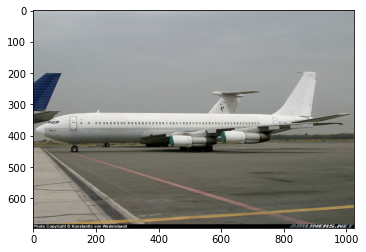

In [57]:
show_image(test_df,10,'manufacturer')

In [68]:
np.argmax(model.predict(X_test[10:20]),axis=1)

array([ 4,  4,  1, 29, 21,  4,  1,  4,  4,  4])

In [101]:
def classify_images(images,model,classes_names=None)->int:
    """Classify images through a tensorflow model.
    
    Parameters:
    -----------
    
    images(np.array): set of images to classify
    model (tensorflow.keras.Model): tensorflow/keras model
    
    Returns
    -------
    predicted classes 
    
    """
    
    results = model.predict(images)
    classes = np.argmax(results,axis=1)
    if classes_names is not None:
        classes = np.array(classes_names[classes])
    return classes

<AxesSubplot:xlabel='col_0', ylabel='row_0'>

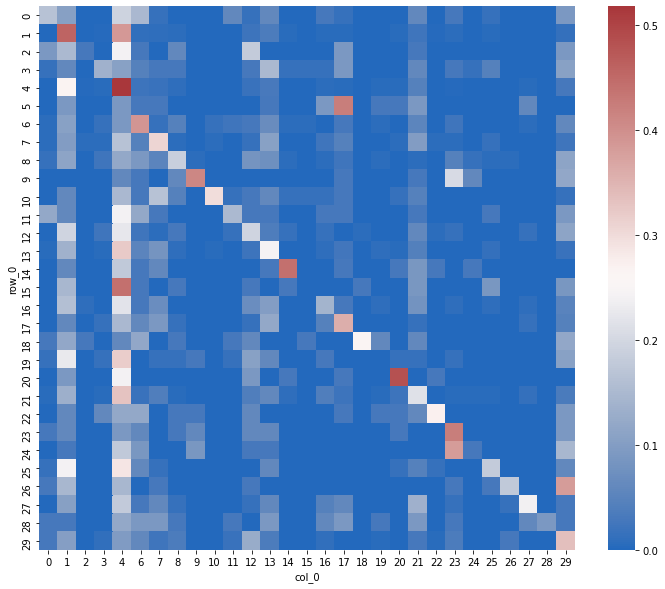

In [83]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(pd.crosstab(np.argmax(y_test,axis=1),classify_images(X_test,model), normalize='index'), cmap='vlag', ax=ax)

<AxesSubplot:xlabel='col_0', ylabel='manufacturer'>

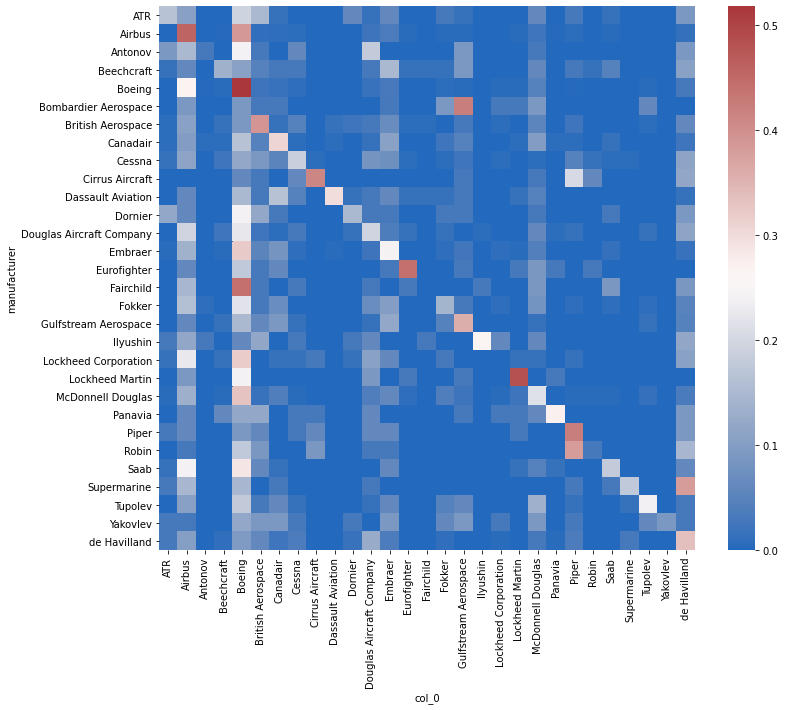

In [106]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(pd.crosstab(test_df['manufacturer'],classify_images(X_test,model,test_df['manufacturer'].astype('category').cat.categories), normalize='index'), cmap='vlag', ax=ax)

<AxesSubplot:xlabel='col_0', ylabel='row_0'>

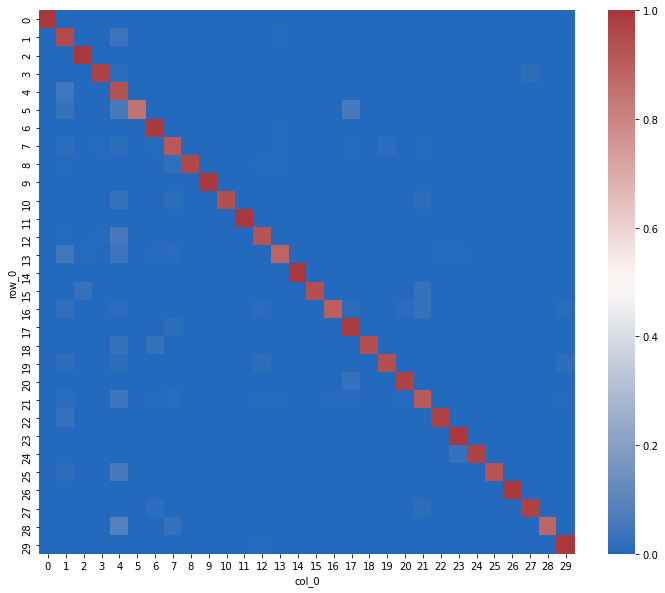

In [111]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(pd.crosstab(np.argmax(y_train,axis=1),classify_images(X_train,model), normalize='index'), cmap='vlag', ax=ax)

<AxesSubplot:xlabel='col_0', ylabel='manufacturer'>

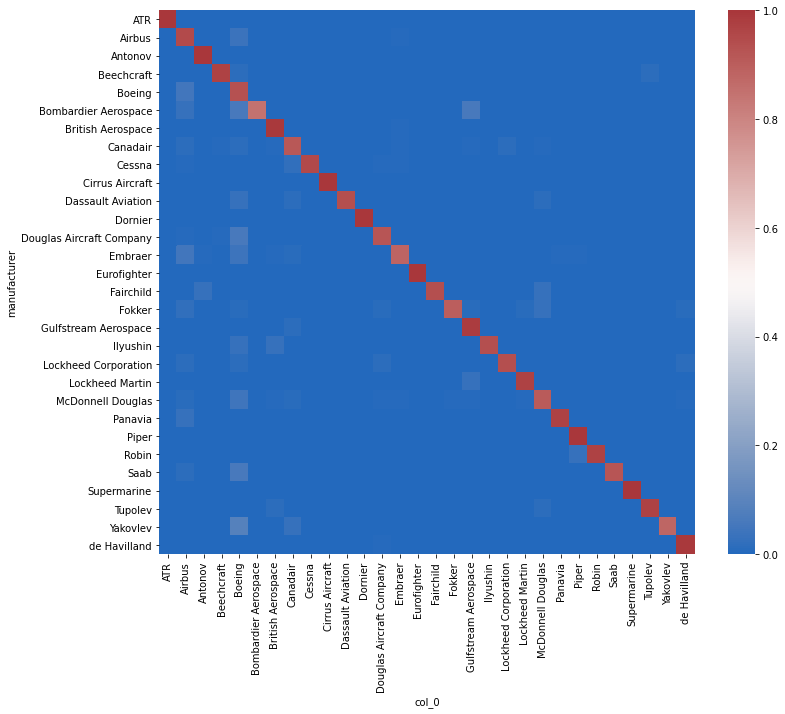

In [110]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(pd.crosstab(train_df['manufacturer'],classify_images(X_train,model,train_df['manufacturer'].astype('category').cat.categories), normalize='index'), cmap='vlag', ax=ax)

In [ ]:
model.save("model/my_model.h5")

In [ ]:
def save_model(model, basename):
      """Save tf/Keras model.

      Model file is named model + timestamp.

      Parameters
      ----------
      model (tf/Keras model): model to be saved
      basename: location to save model file
      """
    model.save('{}_{}.h5'.format(basename, datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')))
    return

In [ ]:
reloaded_model = load_model('../model/my_model.h5')